
# Project: Investigate the European Soccer Database (Kaggle)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


In this dataset more than 25.000 matches, players and teams attributes are listed. 

Over the course of this small analysis I want to answer the following questions:

<ul>
<li>Who are the hightest rated players? (Top 10)</li>
<li>Which players couldn't live up to their potential?</li>
<li>What's the average goals scored per game and league over the years?</li>
</ul>


In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

database = "database.sqlite"

### General Properties

Connect to database and show tables

In [3]:
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


Test to see which countries are represented

In [4]:
countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


<a id='eda'></a>
## Exploratory Data Analysis


### 1) Who are the hightest rated players? (Top 10)?

First, we need to get data with a SQL query.
We need the player's name, average rating, number of ratings and potential (potential will maybe be used in another analysis later)

In [5]:
players_by_rating = pd.read_sql("""SELECT player_name AS name,
                                          avg(PA.overall_rating) AS avg_rating,
                                          count(distinct date) AS ratings,
                                          avg(PA.potential) AS potential
                                    FROM Player
                                    LEFT JOIN Player_Attributes AS PA ON PA.player_api_id = Player.player_api_id
                    
                                    
                                    GROUP BY name 
                                    HAVING count(distinct date) > 20
                                    ORDER BY avg_rating DESC
                                    ;""", conn)
players_by_rating.head(10)

,name,avg_rating,ratings,potential
0,Lionel Messi,92.192308,26,95.230769
1,Cristiano Ronaldo,91.280000,25,93.480000
2,Franck Ribery,88.458333,24,89.916667
3,Andres Iniesta,88.320000,25,90.560000
4,Zlatan Ibrahimovic,88.285714,21,90.047619
5,Arjen Robben,87.840000,25,88.600000
6,Xavi Hernandez,87.636364,22,88.363636
7,Wayne Rooney,87.222222,36,87.944444
8,Iker Casillas,86.954545,22,88.227273
9,Philipp Lahm,86.733333,30,87.533333


Get top 10 names

In [6]:
names_top10 = players_by_rating["name"][:10]
names_top10

0          Lionel Messi
1     Cristiano Ronaldo
2         Franck Ribery
3        Andres Iniesta
4    Zlatan Ibrahimovic
5          Arjen Robben
6        Xavi Hernandez
7          Wayne Rooney
8         Iker Casillas
9          Philipp Lahm
Name: name, dtype: object

Get top 10 average ratings

In [8]:
ratings_top10 = players_by_rating["avg_rating"][:10]
ratings_top10

0    92.192308
1    91.280000
2    88.458333
3    88.320000
4    88.285714
5    87.840000
6    87.636364
7    87.222222
8    86.954545
9    86.733333
Name: avg_rating, dtype: float64

Bar chart seems to be most fitting for the top 10

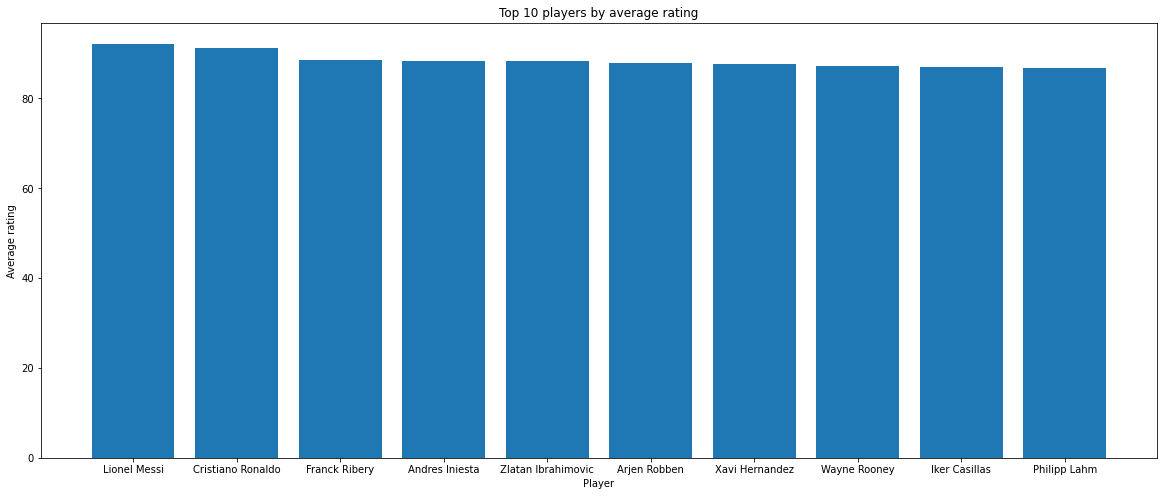

In [9]:
plt.subplots(figsize=(20,8))
plt.bar(names_top10, ratings_top10)

plt.title("Top 10 players by average rating")
plt.ylabel("Average rating")
plt.xlabel("Player");

### 2) Which players couldn't live up to their potential? (Top 10)

We can use players_by_ratings from the previous query for that question

In [10]:
players_by_rating.head(10)

,name,avg_rating,ratings,potential
0,Lionel Messi,92.192308,26,95.230769
1,Cristiano Ronaldo,91.280000,25,93.480000
2,Franck Ribery,88.458333,24,89.916667
3,Andres Iniesta,88.320000,25,90.560000
4,Zlatan Ibrahimovic,88.285714,21,90.047619
5,Arjen Robben,87.840000,25,88.600000
6,Xavi Hernandez,87.636364,22,88.363636
7,Wayne Rooney,87.222222,36,87.944444
8,Iker Casillas,86.954545,22,88.227273
9,Philipp Lahm,86.733333,30,87.533333


We need a new column that shows the difference between potential and average rating

In [12]:
players_by_rating["pot_difference"] = players_by_rating["potential"] - players_by_rating["avg_rating"]
players_by_rating.head()

,name,avg_rating,ratings,potential,pot_difference
0,Lionel Messi,92.192308,26,95.230769,3.038462
1,Cristiano Ronaldo,91.280000,25,93.480000,2.200000
2,Franck Ribery,88.458333,24,89.916667,1.458333
3,Andres Iniesta,88.320000,25,90.560000,2.240000
4,Zlatan Ibrahimovic,88.285714,21,90.047619,1.761905


We need to sort by pot_difference and store it in a new variable

In [15]:
players_by_pot_dif = players_by_rating.sort_values(by="pot_difference", ascending=False)
players_by_pot_dif.head()

,name,avg_rating,ratings,potential,pot_difference
3621,Dele Alli,61.886364,44,81.250000,19.363636
2984,Levin Mete Oztunali,66.307692,26,84.576923,18.269231
3726,Adam Campbell,59.636364,22,77.636364,18.000000
3735,Dawid Kownacki,59.375000,24,76.625000,17.250000
3480,Hector Bellerin,63.464286,28,80.571429,17.107143


Get top 10 names and pot_difference for plotting

In [16]:
names = players_by_pot_dif["name"][:10]
dif = players_by_pot_dif["pot_difference"][:10]

Everything ready for plotting

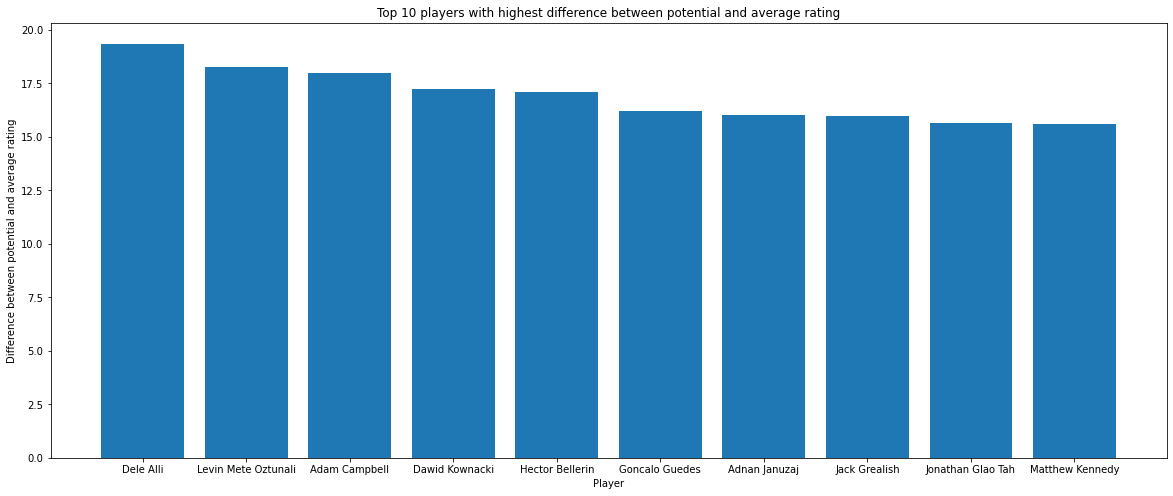

In [17]:
plt.subplots(figsize=(20,8))
plt.bar(names, dif)

plt.title("Top 10 players with highest difference between potential and average rating")
plt.xlabel("Player")
plt.ylabel("Difference between potential and average rating");

### 3) What's the average goals scored per game and league over the years?

For this question we need some more pieces of information. We need to know the averages per country and season. We can compute them them with Python (new column) or directly with SQL (like below).  
We are only interested in the top leagues. 

In [12]:
leagues_by_season = pd.read_sql("""SELECT Country.name AS country_name,
                                            League.name AS league_name,
                                            season,
                                            count(distinct stage) AS stages,
                                            count(distinct home_team_api_id) AS number_of_teams,
                                            avg(home_team_goal) AS avg_home_team_goal,
                                            avg(away_team_goal) AS avg_away_team_goal,
                                            avg(home_team_goal - away_team_goal) AS avg_goal_difference,
                                            avg(home_team_goal + away_team_goal) AS avg_goals,
                                            sum(home_team_goal + away_team_goal) AS total_goals
                                        FROM Match
                                        JOIN Country ON Country.id = Match.country_id
                                        JOIN League ON League.id = Match.league_id
                                        LEFT JOIN Team AS HT ON HT.team_api_id = Match.home_team_api_id
                                        LEFT JOIN Team AS AT ON AT.team_api_id = Match.away_team_api_id
                                        WHERE country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                        
                                        GROUP BY Country.name, League.name, season
                                        ORDER BY Country.name, League.name, season DESC
                                        ;""", conn)
leagues_by_season.head()

,country_name,league_name,season,stages,number_of_teams,avg_home_team_goal,avg_away_team_goal,avg_goal_difference,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066


In the end, we want to have lines for every league. So we need an index (our seasons)

In [13]:
season = leagues_by_season.query("league_name == 'England Premier League'")["season"].sort_index(ascending=False)
season

7    2008/2009
6    2009/2010
5    2010/2011
4    2011/2012
3    2012/2013
2    2013/2014
1    2014/2015
0    2015/2016
Name: season, dtype: object

We need to know the exact names of your leagues

In [14]:
leagues_by_season["league_name"].unique()

array(['England Premier League', 'France Ligue 1',
       'Germany 1. Bundesliga', 'Italy Serie A', 'Spain LIGA BBVA'],
      dtype=object)

Get our data ready for plotting

In [15]:
england_av_goals = leagues_by_season.query("league_name == 'England Premier League'")["avg_goals"].sort_index(ascending=False)
germany_av_goals = leagues_by_season.query("league_name == 'Germany 1. Bundesliga'")["avg_goals"].sort_index(ascending=False)
italy_av_goals = leagues_by_season.query("league_name == 'Italy Serie A'")["avg_goals"].sort_index(ascending=False)
spain_av_goals = leagues_by_season.query("league_name == 'Spain LIGA BBVA'")["avg_goals"].sort_index(ascending=False)
france_av_goals = leagues_by_season.query("league_name == 'France Ligue 1'")["avg_goals"].sort_index(ascending=False)

We can see that Germany has the highest goals per game in every season displayed. France is the lowest scoing league on average. Spain had a dip from 2012/2013 to 2013/2014 when Germany's average goals rose. Maybe one factor was the arrival of Pep Guardiola at Munich in that period. 

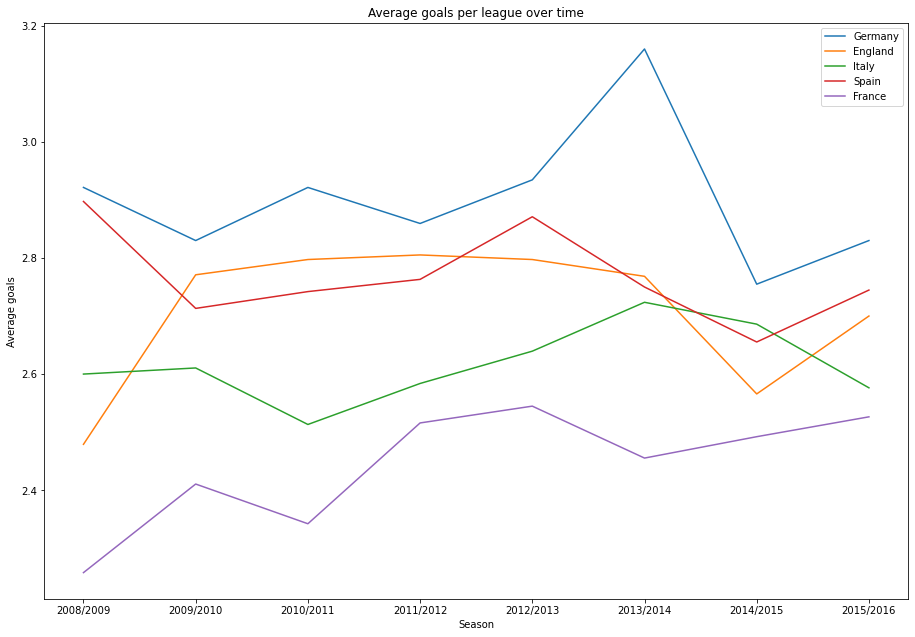

In [16]:
diag = plt.figure()

ax = diag.add_axes([0,0,2,2])

ax.plot(season, germany_av_goals, label = "Germany")
ax.plot(season, england_av_goals, label = "England")
ax.plot(season, italy_av_goals, label = "Italy")
ax.plot(season, spain_av_goals, label = "Spain")
ax.plot(season, france_av_goals, label = "France")


plt.title("Average goals per league over time")
plt.xlabel("Season")
plt.ylabel("Average goals")
plt.legend();

<a id='conclusions'></a>
## Conclusions

BLA

### Limitations

BLA
